# Sensitivity of dv/v with GWL

For a review paper by Denolle et al, 202?


In [ ]:
! pip install pyarrow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pyarrow.feather as feather
from scipy.interpolate import interp1d

## Kim & Lekic 2019
This script is meant to convert the JSON file from a usgs well database (https://waterdata.usgs.gov/monitoring-location/293352095011601/#parameterCode=72019&showMedian=true&startDT=1995-01-01&endDT=2017-01-01) into a workable CSV file.

In [2]:
df = pd.read_json('./data/gwl_texas.json')

convert JSON file to pandas dataframe

In [3]:
data = []
# Loop over each dataStream
for dataStream in df["properties"].dataStreams:
    # Loop over each observation in the dataStream
    for observation in dataStream['observations']:
        # Extract phenomenonTime and result
        phenomenonTime = observation['phenomenonTime']
        date = pd.to_datetime(phenomenonTime)
        result = float(observation['result'])
        # convert results from feet to meters
        result = result * 0.3048
        # Append the extracted data to the list
        data.append({'Date': date, 'DistanceFromSurface': result})
    break

# # Convert the list to a pandas DataFrame
df2 = pd.DataFrame(data)

# Convert phenomenonTime to datetime object with just year-month-day
df2['Date'] = pd.to_datetime(df2['Date']).dt.date

# Sort the DataFrame by the 'Date' column
df2 = df2.sort_values(by='Date')
# Reset the index of the DataFrame
df2 = df2.reset_index(drop=True)


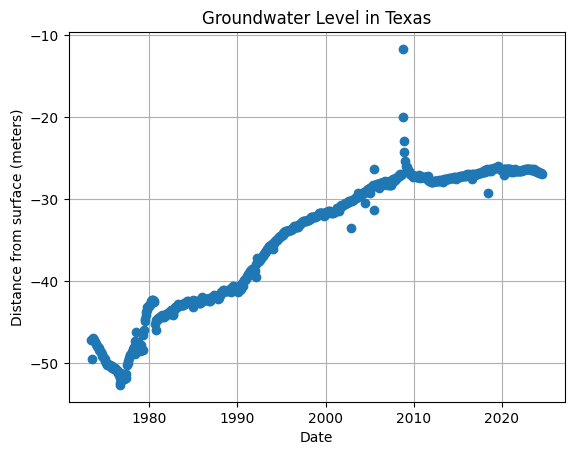

In [4]:
# plot the GWL in Texas
plt.plot_date(df2['Date'], df2['DistanceFromSurface'])
plt.xlabel('Date')
plt.ylabel('Distance from surface (meters)')
plt.grid()
plt.title('Groundwater Level in Texas')
plt.show()

Add the dv/v time series

In [5]:
# this wioll read in data/Kim_lekic folder reading the .dat files as a pandas dataframe
dv = pd.read_csv('/Users/marinedenolle/GIT_REPOS/dvv-hydro-CompGeo-review-2024/data/Kim_Lekic_2019_Seismic_velocity_perturbations_from_ambient_noise/1dv_v_BHE_PWS.dat', sep='\s+', header=None, names=['time', 'x', 'y', 'z'])

## Clements&Denolle 2018

In [7]:
dvv_clements = pd.read_csv('/Users/marinedenolle/GIT_REPOS/dvv-hydro-CompGeo-review-2024/data/Clements_Denolle_2018/clements-denolle-grl-2018-figure-2.csv')
dvv_clements.head()

,time,dvv,gwl
0,2000-01-01,-0.051872,70.908261
1,2000-01-02,-0.053723,70.898545
2,2000-01-03,-0.055540,70.888987
3,2000-01-04,-0.057322,70.879587
4,2000-01-05,-0.059071,70.870344


## Clements and Denolle 2023

Read LJR and compare with well level

In [25]:
# now we will read data from Clements_Denolle_2023 and plot the TSV data and the LJR arrow data onto the same plot
# dvv_clements = pd.read_csv('/Users/marinedenolle/GIT_REPOS/dvv-hydro-CompGeo-review-2024/data/Clements_Denolle_2018/clements-denolle-grl-2018-figure-2.csv')
# Read the PyArrow file
dvv_clements23 = feather.read_table('/Users/marinedenolle/GIT_REPOS/dvv-hydro-CompGeo-review-2024/data/Clements_Denolle_2023/CI.LJR.arrow')
# convert the DATE column to a pandas datetime object
dvv_clements23['DATE'] = pd.to_datetime(dvv_clements23['DATE'])
# Convert to a pandas DataFrame
dvv_clements23_df = dvv_clements23.to_pandas()
dvv_clements23_df.head()

,DATE,DVV,CC
0,2002-11-12,-0.154860,0.974293
1,2002-11-13,-0.156883,0.975337
2,2002-11-14,-0.159417,0.974473
3,2002-11-15,-0.115709,0.974992
4,2002-11-16,-0.143005,0.974008


In [37]:
# read the groundwater level from the TSV file in the same directory
pd_gwl_ljr = pd.read_csv('/Users/marinedenolle/GIT_REPOS/dvv-hydro-CompGeo-review-2024/data/Clements_Denolle_2023/344614118454101.tsv', sep='\t', comment='#')
# convert the DATE column to a pandas datetime object
pd_gwl_ljr['DATE'] = pd.to_datetime(pd_gwl_ljr['lev_dt'])
pd_gwl_ljr.head()

,agency_cd,site_no,site_tp_cd,lev_dt,lev_tm,lev_tz_cd,lev_va,sl_lev_va,sl_datum_cd,lev_status_cd,lev_agency_cd,lev_dt_acy_cd,lev_acy_cd,lev_src_cd,lev_meth_cd,lev_age_cd,DATE
0,USGS,344614118454101,GW,1958-11-25,NaN,NaN,NaN,3250.00,NGVD29,1,CA001,D,NaN,A,O,A,1958-11-25
1,USGS,344614118454101,GW,1958-11-25,NaN,NaN,NaN,3252.97,NAVD88,1,CA001,D,NaN,A,O,A,1958-11-25
2,USGS,344614118454101,GW,1958-11-25,NaN,NaN,120.0,NaN,NaN,1,CA001,D,NaN,A,O,A,1958-11-25
3,USGS,344614118454101,GW,1959-03-17,NaN,NaN,NaN,3285.70,NGVD29,1,CA001,D,NaN,A,O,A,1959-03-17
4,USGS,344614118454101,GW,1959-03-17,NaN,NaN,NaN,3288.67,NAVD88,1,CA001,D,NaN,A,O,A,1959-03-17


In [44]:
# find the non-NaN values of lev_va
iloc = (pd_gwl_ljr['lev_va'].notna()) & (pd_gwl_ljr['lev_va'] < 50)

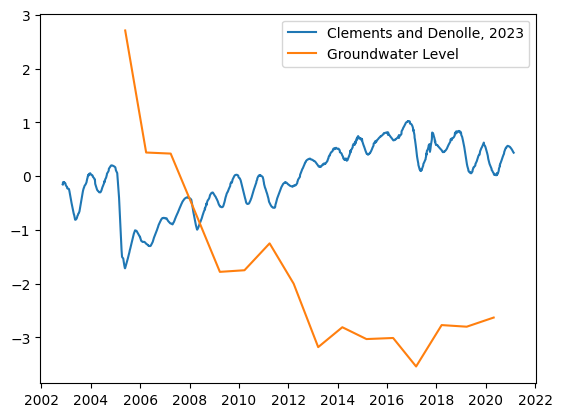

In [48]:
plt.plot(dvv_clements23_df['DATE'],dvv_clements23_df['DVV'],label='Clements and Denolle, 2023')
plt.plot(pd_gwl_ljr['DATE'][iloc],-(pd_gwl_ljr['lev_va'][iloc]-25),label='Groundwater Level')
plt.legend()

In [74]:
# interpolate the groundwater level to the same time as the dvv data


# first convert datetime to seconds
dvv_clements23_df['TIMESTAMP'] = pd.to_datetime(dvv_clements23_df['DATE'])

# Convert the 'TIMESTAMP' column to seconds since the epoch
dvv_clements23_df['TIMESTAMP_SECONDS'] = dvv_clements23_df['TIMESTAMP'].apply(lambda x: x.timestamp())


# Convert the 'DATE' column to datetime for pd_gwl_ljr
pd_gwl_ljr['TIMESTAMP'] = pd.to_datetime(pd_gwl_ljr['DATE'])

# Convert the 'TIMESTAMP' column to seconds since the epoch for pd_gwl_ljr
pd_gwl_ljr['TIMESTAMP_SECONDS'] = pd_gwl_ljr['TIMESTAMP'].apply(lambda x: x.timestamp())


In [75]:

# Filter out rows with NaN values in 'lev_va'
pd_gwl_ljr_filtered = pd_gwl_ljr.dropna(subset=['lev_va'])

# Create an interpolation function for 'lev_va' based on 'TIMESTAMP_SECONDS'
interp_func = interp1d(pd_gwl_ljr_filtered['TIMESTAMP_SECONDS'], pd_gwl_ljr_filtered['lev_va'], bounds_error=False, fill_value="extrapolate")

# Interpolate 'lev_va' onto the same dates as dvv_clements23_df['TIMESTAMP_SECONDS']
dvv_clements23_df['lev_va_interpolated'] = interp_func(dvv_clements23_df['TIMESTAMP_SECONDS'])

# Display the first few rows to verify the new column
print(dvv_clements23_df.head())

         DATE       DVV        CC  TIMESTAMP  TIMESTAMP_SECONDS  \
0  2002-11-12 -0.154860  0.974293 2002-11-12       1.037059e+09   
1  2002-11-13 -0.156883  0.975337 2002-11-13       1.037146e+09   
2  2002-11-14 -0.159417  0.974473 2002-11-14       1.037232e+09   
3  2002-11-15 -0.115709  0.974992 2002-11-15       1.037318e+09   
4  2002-11-16 -0.143005  0.974008 2002-11-16       1.037405e+09   

   lev_va_interpolated  
0            29.171383  
1            29.163935  
2            29.156488  
3            29.149040  
4            29.141593  


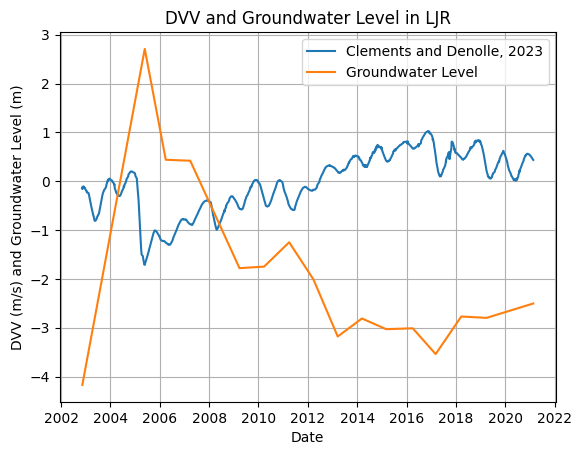

In [76]:
# now plot the interpolated data and the dvv data
plt.plot(dvv_clements23_df['DATE'],dvv_clements23_df['DVV'],label='Clements and Denolle, 2023')
plt.plot(dvv_clements23_df['DATE'],-(dvv_clements23_df['lev_va_interpolated']-25),label='Groundwater Level demeaned')
plt.legend()
plt.xlabel('Date')
plt.ylabel('DVV (m/s) and Groundwater Level (m)')
plt.title('DVV and Groundwater Level in LJR')
plt.grid()

## All together

Sensitivity (slope) for Clements and Denolle (2018): -0.0090048227185856
Sensitivity (slope) for Clements and Denolle (2023): -0.31868504349214866


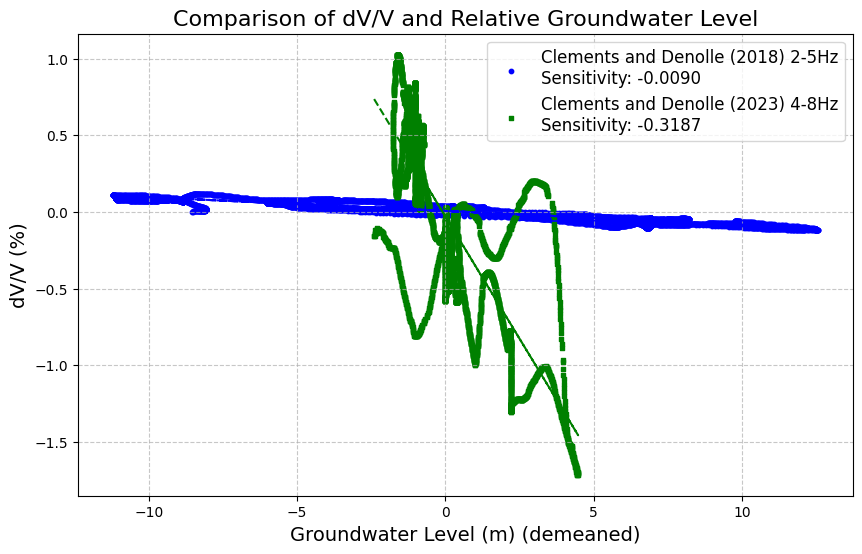

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming dvv_clements and dvv_clements23_df are already defined

# Calculate the mean GWL for both datasets
mean_CD18_GW = dvv_clements['gwl'].mean()
mean_CD23_GW = dvv_clements23_df['lev_va_interpolated'].mean()

# Demean the GWL values
demeaned_gwl_CD18 = dvv_clements['gwl'] - mean_CD18_GW
demeaned_gwl_CD23 = -(dvv_clements23_df['lev_va_interpolated'] - mean_CD23_GW)

# Perform linear regression for both datasets
slope_CD18, intercept_CD18, r_value_CD18, p_value_CD18, std_err_CD18 = linregress(demeaned_gwl_CD18, dvv_clements['dvv'])
slope_CD23, intercept_CD23, r_value_CD23, p_value_CD23, std_err_CD23 = linregress(demeaned_gwl_CD23, dvv_clements23_df['DVV'])

# Print the slopes (sensitivities)
print(f"Sensitivity (slope) for Clements and Denolle (2018): {slope_CD18}")
print(f"Sensitivity (slope) for Clements and Denolle (2023): {slope_CD23}")

# Plot the data
plt.figure(figsize=(10, 6))

# Scatter plots
plt.scatter(demeaned_gwl_CD18, dvv_clements['dvv'], s=10, color='blue', marker='o', label=f'Clements and Denolle (2018) 2-5Hz\nSensitivity: {slope_CD18:.4f}')
plt.scatter(demeaned_gwl_CD23, dvv_clements23_df['DVV'], s=10, color='green', marker='s', label=f'Clements and Denolle (2023) 4-8Hz\nSensitivity: {slope_CD23:.4f}')

# Trend lines
plt.plot(demeaned_gwl_CD18, intercept_CD18 + slope_CD18 * demeaned_gwl_CD18, color='blue', linestyle='--')
plt.plot(demeaned_gwl_CD23, intercept_CD23 + slope_CD23 * demeaned_gwl_CD23, color='green', linestyle='--')

# Labels and title
plt.xlabel('Groundwater Level (m) (demeaned)', fontsize=14)
plt.ylabel('dV/V (%)', fontsize=14)
plt.title('Comparison of dV/V and Relative Groundwater Level', fontsize=16)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Show plot
plt.show()